In [60]:
import os
import numpy as np
import networkx as nx
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster, inconsistent, maxdists, cophenet
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabaz_score
%matplotlib inline
#pylab.rcParams['figure.figsize'] = (10, 6)

In [61]:
def results(Z, nclusters, labels):
    res = cut_tree(Z, nclusters).flatten()
    return list(zip(labels, res))

def elbow(Z):
    last = Z[-12:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last)+1)
    acceleration = np.diff(last, 2)
    acceleration_rev = acceleration[::-1]
    #plt.subplot(211)
    plt.xticks(idxs)
    plt.plot(idxs, last_rev,'b*-')
    #plt.plot(idxs[4], last_rev[4], marker='o', markersize=12,markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    #plt.subplot(212)
    #plt.xticks(idxs[:-2])
    #plt.plot(idxs[:-2], acceleration_rev)
    #print("acceleration", acceleration_rev.argmax()+2)
    
def elbow_2(Z):
    last = Z[-10:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    slopes = []
    for i in range(len(idxs)-1):
        slopes.append(last_rev[i] - last_rev[i+1])
    return [(i+1,j) for (i,j) in enumerate(slopes)]

def elbow_3(Z):
    last = Z[-10:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    p1 = np.array([1, last_rev[0]])
    p2 = np.array([10, last_rev[-1]])
    d = []
    for i in range(2,len(last)):
        p3 = np.array([i, last_rev[i-1]])
        d.append(np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1))
    return d
    
    
def silhouette(X, Z):
    s = -10
    j = 0
    for i in range(2, Z.shape[0]+1):
        nodes = cut_tree(Z, i).flatten()
        sc = silhouette_score(X, nodes)
        if sc > s:
            s = sc
            j = i
    return j

def calinski(X, Z):
    s = -10
    j = 0
    for i in range(2, Z.shape[0]+1):
        nodes = cut_tree(Z, i).flatten()
        sc = calinski_harabaz_score(X, nodes)
        if sc > s:
            s = sc
            j = i
    return j

def silhouette_coefficient(clusters, r):
    #N =  sum(map(len, clusters))
    N = sum([len(i) for i in clusters])
    idx = np.arange(N)
    a = np.zeros(N)
    b = np.zeros(N)
    for C in np.array(list(map(np.sort, clusters))):
        D = list(filter(lambda x: x not in C, idx))
        m = len(C)
        n = len(D)
        for i in range(m):
            # Cohesion
            for j in range(i):
                a[C[i]] += r[C[i], C[j]]
            for j in range(i+1, m):
                a[C[i]] += r[C[i], C[j]]
            a[C[i]] /= max(1, m)
            # Separation
            for j in range(n):
                b[C[i]] += r[C[i], D[j]]
            b[C[i]] /= max(1, m)
    s = b-a
    return sum(s) / N*1.0

def minimum_sc(Z, r):
    N = Z.shape[0]
    sc = np.inf
    min_clusters = None
    for i in range(1, N+1):
        # Gets the clusters defined by the i-th tree level in hthe hierarchy
        clusters = extract_clusters(Z, i)
        sc_i = silhouette_coefficient(clusters, r)
        if (sc_i < sc):
            sc = sc_i
            min_clusters = clusters
    return min_clusters

def extract_clusters(Z, n):
    CT = cut_tree(Z, n_clusters=n, height=None).flatten()
    #print(CT)
    clusters = []
    for i in range(n):
        clusters.append(np.where(CT == i)[0])
    return clusters

def propio(Z, c=0.99):
    dist = Z[:,2]
    corte = None
    for i,d in enumerate(dist):
        if c < d:
            corte = i
            break
    n_clusters = Z.shape[0] - i
    return n_clusters
    
def make_dendrogram(Z, labels):
    dendrogram(Z, orientation='right', labels = labels, color_threshold=Z[Z.shape[0]-6, 2]+0.001)
    plt.savefig('dendro.png')
    
def crea_results(results_path, method, Z, n):
    f = open(results_path + '/elements.txt', 'r')
    elements = f.read().split(',')
    f.close()
    clusters = extract_clusters(Z, n)
    os.mkdir(os.path.join(results_path, method))
    cluster_file = open(os.path.join(results_path, method, 'clusters.txt'), 'w')
    for i in range(len(clusters)):
        cluster_str = ','.join(list(map(lambda j: elements[j], clusters[i])))
        cluster_file.write(cluster_str + '\n')
    cluster_file.close()

In [26]:
from sklearn import decomposition

prueba = 'roc3'
p = '/Users/Gago/Desktop/Universidad/Master/TFM/pruebas'
noise_path = os.path.join(p, prueba, 'noise')
results_path = os.path.join(p, prueba, 'Results')
c = os.path.join(p, prueba, 'Results', 'corr.npy')
files = sorted(os.listdir(noise_path))
s = np.load(c)

#dis = np.corrcoef(s)
#dis = np.divide(1+ 1e-10 +s,1 + 1e-10 - s)
dis = 1-s
labels = [x for x in sorted(files)]

In [27]:
Z = linkage(dis, method='ward')
#cophenet(Z)

In [28]:
calinski(dis, Z)

2

In [29]:
silhouette(dis, Z)

4

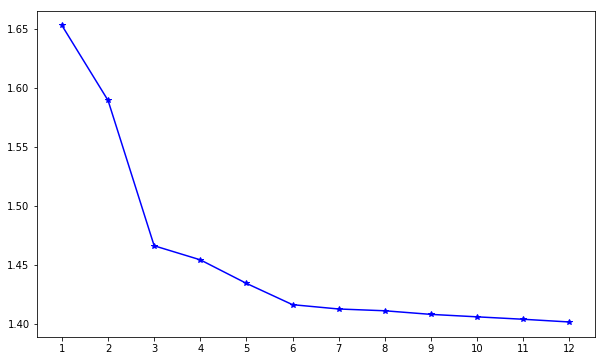

In [30]:
elbow(Z)

In [35]:
results(Z, 6, labels)

[('bq_aquaris_e5_VID_20160107_120206.mp4.npy', 0),
 ('bq_aquaris_e5_VID_20160107_120224.mp4.npy', 0),
 ('bq_aquaris_e5_VID_20160107_120239.mp4.npy', 0),
 ('bq_aquaris_e5_VID_20160107_120327.mp4.npy', 0),
 ('bq_aquaris_e5_VID_20160107_120341.mp4.npy', 0),
 ('bq_aquaris_e5_VID_20160107_120519.mp4.npy', 0),
 ('bq_aquaris_e5_VID_20160107_120554.mp4.npy', 0),
 ('iphone7_roberto_IMG_5680.mov.npy', 1),
 ('iphone7_roberto_IMG_5683.mov.npy', 2),
 ('iphone7_roberto_IMG_5685.mov.npy', 2),
 ('iphone7_roberto_IMG_5686.mov.npy', 1),
 ('iphone7_roberto_IMG_5687.mov.npy', 2),
 ('nexus_VID_20160108_095500.mp4.npy', 3),
 ('nexus_VID_20160108_095541.mp4.npy', 3),
 ('nexus_VID_20160108_095557.mp4.npy', 3),
 ('nexus_VID_20160108_095621.mp4.npy', 3),
 ('nexus_VID_20160108_095716.mp4.npy', 3),
 ('nexus_VID_20160108_095732.mp4.npy', 3),
 ('samsung_g6_20160203_161340.mp4.npy', 4),
 ('samsung_g6_20160203_161415.mp4.npy', 4),
 ('samsung_g6_20160203_161448.mp4.npy', 4),
 ('samsung_g6_20160203_161532.mp4.npy', 4),

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       0.00      0.00      0.00         0
          2       1.00      0.60      0.75         5
          3       1.00      1.00      1.00         6
          4       1.00      1.00      1.00         4
          5       1.00      1.00      1.00         5

avg / total       1.00      0.93      0.95        27



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


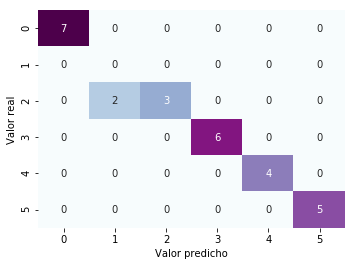

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
y_true=[0,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,5,5,5,5,5]
y_pred=[0,0,0,0,0,0,0,1,2,2,1,2,3,3,3,3,3,3,4,4,4,4,5,5,5,5,5]
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True, cmap="BuPu", cbar=False)
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
print(classification_report(y_true, y_pred))

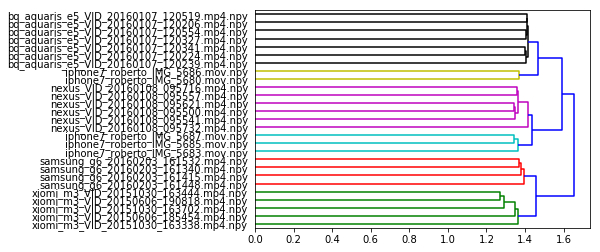

In [62]:
make_dendrogram(Z, labels)

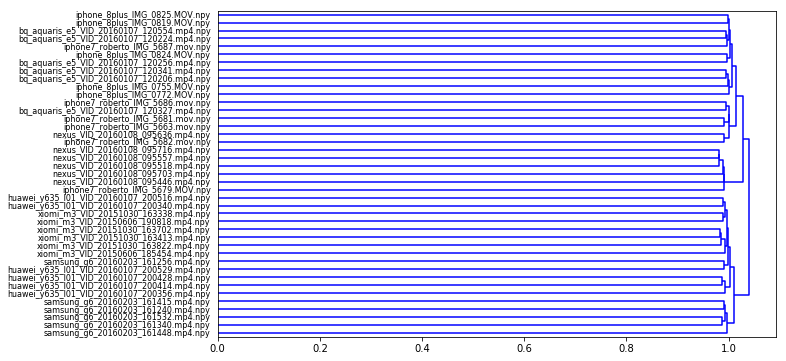

In [51]:
make_dendrogram(Z, labels)